# Chapter 3.6. MNIST on TensorFlow

Original code in Nikolenko book was made in **TensorFlow 1.x (TF1)**, but here I will convert examples to **TensorFlow 2.0 (TF2)**.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from models_classes import (
    LogRegModel,
    HidLayerModel
)
from losses import cross_entropy_loss
from metrics import accuracy
from utils import (
    _fix_seeds,
    plot_metric_history,
    show_images
)

matplotlib.style.use('seaborn-poster')

## 1. Load data and visualize some examples

- MNIST have 70k images (1 channel) with size of 28x28 (784 if flatten). 
- Samples have already splitted into train (60k images) and test (10k images). 
- Target classes in categorical view

In [2]:
mnist = tf.keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = mnist
X_train, X_test = X_train / 255.0, X_test / 255.0

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


### Visualization:

Visualization methods (`show_images`, `plot_metric_history`) located in `utils.py`

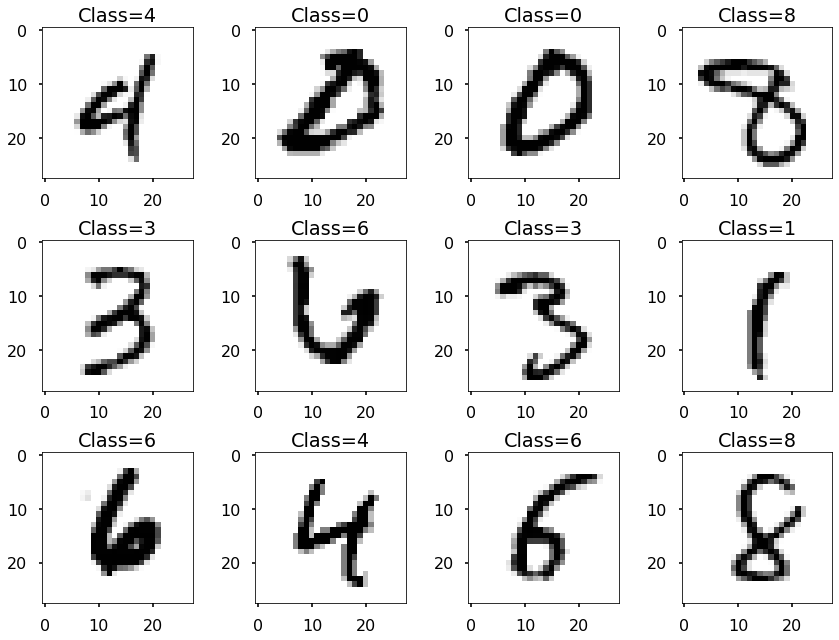

In [4]:
show_images(X_train, y_train, random_sample=True, seed=42, sample_size=12, num_cols=4)

## 2. Train and evaluate logistic regression using TF2

- Set constats
- Define train and evaluation process
- Initialize weigts
- Set model and optimier
- Loop over epochs (book way: "every epoch = one random batch" - to my mind it leads to unstable results)
- Collect loss and metrics (accuracy) values
- Plot metrics history

In [3]:
# set constants
_fix_seeds(42)

batch_size = 128
num_steps = 2000
display_step = 100

# define train proces
def train(model, X, y, optimizer):
    """
    One step of train process
    
    params:
        model: model object to train
        X: data
        y: target 
        optimizer: tf optimizer
    return:
        loss_val: loss value
    """
    with tf.GradientTape() as t:
        y_pred = tf.nn.softmax(model(X))
        loss_val = cross_entropy_loss(y, y_pred)
        
    grads = t.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    acc = accuracy(y, y_pred)
    
    return loss_val, acc

# define evaluate proces
def evaluate(model, X, y):
    """
    One step of evaluation process
    
    params:
        model: model object to evaluate
        X: data to evaluate
        y: target 
    return:
        loss_val: loss value
    """
    y_pred = tf.nn.softmax(model(X))
    loss_val = cross_entropy_loss(y, y_pred)
    
    acc = accuracy(y, y_pred)
    
    return loss_val, acc

In [6]:
# Initialize weigts 
W = tf.Variable(tf.random.normal([784, 10], dtype='float32'), name='weights')
b = tf.Variable(tf.zeros([10], dtype='float32'), name='biases')

# Set up model and optimier
model = LogRegModel(W, b)
optimizer = tf.optimizers.Adam(learning_rate=1e-2)

# collect metrics
loss_history = {
    'train': [],
    'test': []
}
acc_history = {
    'train': [],
    'test': []
}

# running optimization
for i in range(num_steps):
    
    # select train data batch
    indices = np.random.choice(len(X_train), batch_size)
    X_train_batch, y_train_batch = X_train[indices], y_train[indices]
    
    # Flatten data and make ohe over target
    X_train_batch_flat = tf.cast(X_train_batch.reshape(batch_size, 784), tf.float32)
    y_train_batch_ohe = tf.cast(tf.one_hot(y_train_batch, 10), tf.float32)
    
    # train model
    train_loss, train_acc = train(model, X_train_batch_flat, y_train_batch_ohe, optimizer)
    
    # select test data batch
    indices = np.random.choice(len(X_test), batch_size)
    X_test_batch, y_test_batch = X_test[indices], y_test[indices]
    
    # Flatten data and make ohe over target
    X_test_batch_flat = tf.cast(X_test_batch.reshape(batch_size, 784), tf.float32)
    y_test_batch_ohe = tf.cast(tf.one_hot(y_test_batch, 10), tf.float32)    
    
    # evaluate model
    test_loss, test_acc = evaluate(model, X_test_batch_flat, y_test_batch_ohe)
    
    # collect current metrics
    loss_history['train'].append(train_loss.numpy())
    loss_history['test'].append(test_loss.numpy())
    acc_history['train'].append(train_acc)
    acc_history['test'].append(test_acc)
    
    # output info
    if (i+1) % display_step == 0:
        print(f'Epoch {i+1}: train loss={train_loss.numpy()}, train acc={train_acc}')
        print(f'\t\ttest loss={test_loss.numpy()}, test acc={test_acc}\n')

Epoch 100: train loss=-0.42527493834495544, train acc=0.6171875
		test loss=-0.423614501953125, test acc=0.6015625

Epoch 200: train loss=-0.45459648966789246, train acc=0.6484375
		test loss=-0.4928797483444214, test acc=0.7109375

Epoch 300: train loss=-0.5159692764282227, train acc=0.7421875
		test loss=-0.4420052170753479, test acc=0.625

Epoch 400: train loss=-0.4747624397277832, train acc=0.6875
		test loss=-0.5087368488311768, test acc=0.734375

Epoch 500: train loss=-0.512468159198761, train acc=0.734375
		test loss=-0.5581157207489014, test acc=0.8046875

Epoch 600: train loss=-0.5431522130966187, train acc=0.78125
		test loss=-0.5191307067871094, test acc=0.75

Epoch 700: train loss=-0.5390471816062927, train acc=0.765625
		test loss=-0.4755876064300537, test acc=0.6875

Epoch 800: train loss=-0.5464346408843994, train acc=0.796875
		test loss=-0.5282319784164429, test acc=0.765625

Epoch 900: train loss=-0.5551012754440308, train acc=0.8046875
		test loss=-0.5277395248413086

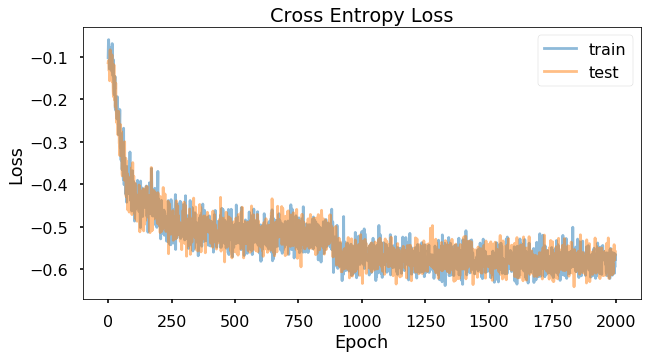

In [7]:
plot_metric_history(loss_history, title='Cross Entropy Loss')

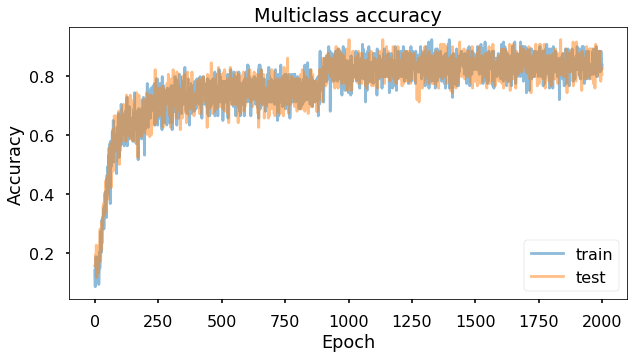

In [8]:
plot_metric_history(acc_history, title='Multiclass accuracy', ylabel='Accuracy')

## 3. Repeat experiment 100 times and average results

In [5]:
def one_experiment(X_train, y_train, X_test, y_test, \
                   model, optimizer, 
                   num_steps=2000, batch_size=128):
    """
    Run one experiment.
    
    returns:
        loss_history: dict of lists
        acc_history: dict of lists
    """
    # collect metrics
    loss_history = {
        'train': [],
        'test': []
    }
    acc_history = {
        'train': [],
        'test': []
    }

    # running optimization
    for i in range(num_steps):

        # select train data batch
        indices = np.random.choice(len(X_train), batch_size)
        X_train_batch, y_train_batch = X_train[indices], y_train[indices]

        # Flatten data and make ohe over target
        X_train_batch_flat = tf.cast(X_train_batch.reshape(batch_size, 784), tf.float32)
        y_train_batch_ohe = tf.cast(tf.one_hot(y_train_batch, 10), tf.float32)

        # train model
        train_loss, train_acc = train(model, X_train_batch_flat, y_train_batch_ohe, optimizer)

        # select test data batch
        indices = np.random.choice(len(X_test), batch_size)
        X_test_batch, y_test_batch = X_test[indices], y_test[indices]

        # Flatten data and make ohe over target
        X_test_batch_flat = tf.cast(X_test_batch.reshape(batch_size, 784), tf.float32)
        y_test_batch_ohe = tf.cast(tf.one_hot(y_test_batch, 10), tf.float32)    

        # evaluate model
        test_loss, test_acc = evaluate(model, X_test_batch_flat, y_test_batch_ohe)

        # collect current metrics
        loss_history['train'].append(train_loss.numpy())
        loss_history['test'].append(test_loss.numpy())
        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        
    return loss_history, acc_history

In [11]:
%%time
lr = 1e-2
batch_size = 128
num_steps = 1000
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Initialize weigts 
    W = tf.Variable(tf.random.normal([784, 10], dtype='float32'), name='weights')
    b = tf.Variable(tf.zeros([10], dtype='float32'), name='biases')
    
    # Set up model and optimier
    model = LogRegModel(W, b)
    optimizer = tf.optimizers.Adam(learning_rate=lr)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size)
        
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)

100%|██████████| 100/100 [06:06<00:00,  3.66s/it]

CPU times: user 7min 55s, sys: 18.6 s, total: 8min 14s
Wall time: 6min 6s


In [12]:
loss_plain_mtrx = {
    'train':[],
    'test':[]
}
acc_plain_mtrx = {
    'train':[],
    'test':[]    
}

for exp_loss, exp_acc in zip(loss_history_exp, acc_history_exp):
    loss_plain_mtrx['train'].append(exp_loss['train'])
    loss_plain_mtrx['test'].append(exp_loss['test'])
    
    acc_plain_mtrx['train'].append(exp_acc['train'])
    acc_plain_mtrx['test'].append(exp_acc['test'])  

In [13]:
loss_plain_mtrx['train'] = np.array(loss_plain_mtrx['train'])
loss_plain_mtrx['test'] = np.array(loss_plain_mtrx['test'])

acc_plain_mtrx['train'] = np.array(acc_plain_mtrx['train'])
acc_plain_mtrx['test'] = np.array(acc_plain_mtrx['test'])

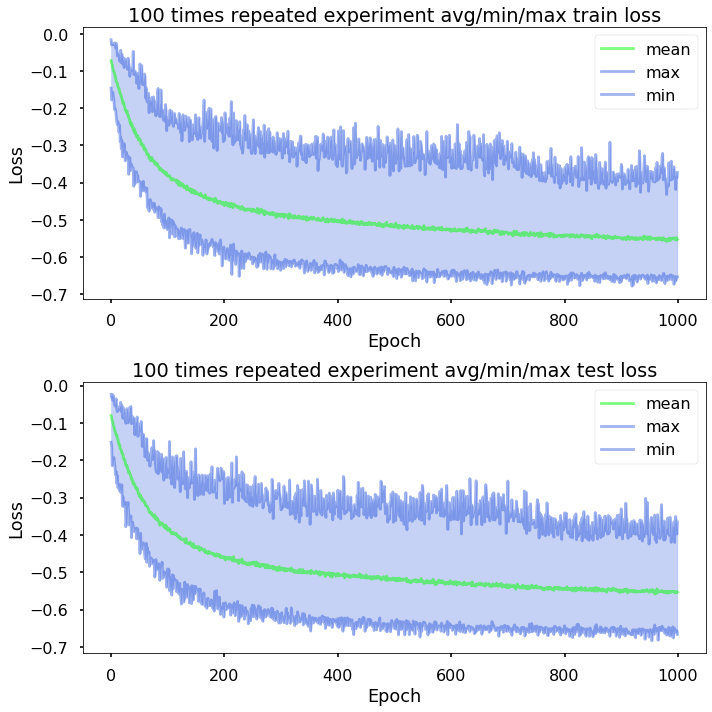

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(loss_plain_mtrx['train'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[0].plot(loss_plain_mtrx['train'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[0].plot(loss_plain_mtrx['train'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[0].fill_between(list(range(1000)), 
                 loss_plain_mtrx['train'].max(axis=0),
                 loss_plain_mtrx['train'].min(axis=0), alpha=0.3, color='royalblue')

ax[0].set_title('100 times repeated experiment avg/min/max train loss' )
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(loss_plain_mtrx['test'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[1].plot(loss_plain_mtrx['test'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[1].plot(loss_plain_mtrx['test'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[1].fill_between(list(range(1000)), 
                 loss_plain_mtrx['test'].max(axis=0),
                 loss_plain_mtrx['test'].min(axis=0), alpha=0.3, color='royalblue')

ax[1].set_title('100 times repeated experiment avg/min/max test loss' )
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.tight_layout()
plt.show()

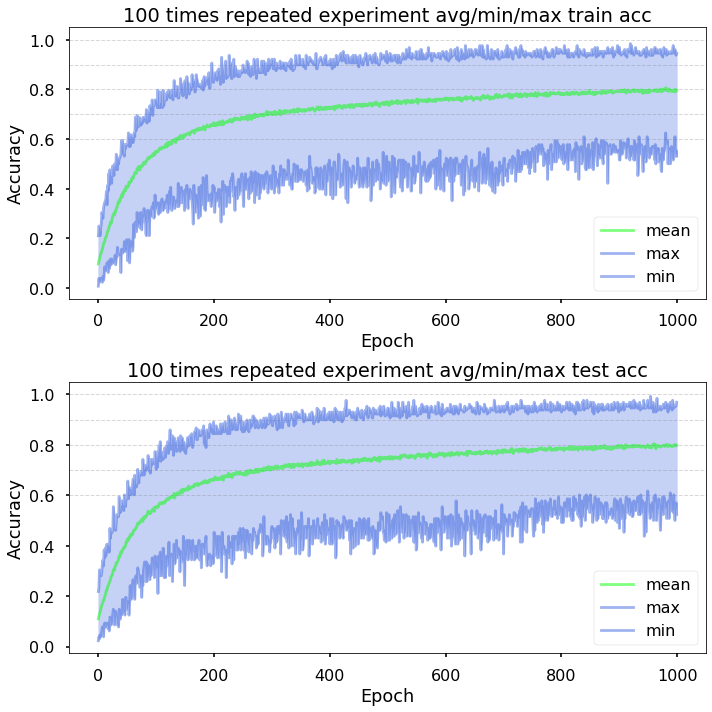

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].axhline(y=1.0, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.9, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.8, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.7, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.6, c='grey', alpha=0.3, ls='--', lw=1)

ax[0].plot(acc_plain_mtrx['train'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[0].plot(acc_plain_mtrx['train'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[0].plot(acc_plain_mtrx['train'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[0].fill_between(list(range(1000)), 
                 acc_plain_mtrx['train'].max(axis=0),
                 acc_plain_mtrx['train'].min(axis=0), alpha=0.3, color='royalblue')

ax[0].set_title('100 times repeated experiment avg/min/max train acc' )
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].axhline(y=1.0, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.9, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.8, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.7, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.6, c='grey', alpha=0.3, ls='--', lw=1)

ax[1].plot(acc_plain_mtrx['test'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[1].plot(acc_plain_mtrx['test'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[1].plot(acc_plain_mtrx['test'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[1].fill_between(list(range(1000)), 
                 acc_plain_mtrx['test'].max(axis=0),
                 acc_plain_mtrx['test'].min(axis=0), alpha=0.3, color='royalblue')

ax[1].set_title('100 times repeated experiment avg/min/max test acc' )
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

## 4. Train and evaluate model with hidden layer using TF2

In [4]:
%%time
# set constants
_fix_seeds(42)

batch_size = 128
num_steps = 2000
display_step = 100
hidden_layer_size = 100
lr = 1e-2

# Initialize weigts
W_relu = tf.Variable(tf.random.normal([784, hidden_layer_size], dtype='float32'), name='weights1')
b_relu = tf.Variable(tf.zeros([hidden_layer_size], dtype='float32'), name='biases1')
W_logit = tf.Variable(tf.random.normal([hidden_layer_size, 10], dtype='float32'), name='weights2')
b_logit = tf.Variable(tf.zeros([10], dtype='float32'), name='biases2')

# Set up model and optimier
model = HidLayerModel(W_relu, b_relu, W_logit, b_logit)
optimizer = tf.optimizers.Adam(learning_rate=lr)

# collect metrics
loss_history = {
    'train': [],
    'test': []
}
acc_history = {
    'train': [],
    'test': []
}

# running optimization
for i in range(num_steps):
    
    # select train data batch
    indices = np.random.choice(len(X_train), batch_size)
    X_train_batch, y_train_batch = X_train[indices], y_train[indices]
    
    # Flatten data and make ohe over target
    X_train_batch_flat = tf.cast(X_train_batch.reshape(batch_size, 784), tf.float32)
    y_train_batch_ohe = tf.cast(tf.one_hot(y_train_batch, 10), tf.float32)
    
    # train model
    train_loss, train_acc = train(model, X_train_batch_flat, y_train_batch_ohe, optimizer)
    
    # select test data batch
    indices = np.random.choice(len(X_test), batch_size)
    X_test_batch, y_test_batch = X_test[indices], y_test[indices]
    
    # Flatten data and make ohe over target
    X_test_batch_flat = tf.cast(X_test_batch.reshape(batch_size, 784), tf.float32)
    y_test_batch_ohe = tf.cast(tf.one_hot(y_test_batch, 10), tf.float32)    
    
    # evaluate model
    test_loss, test_acc = evaluate(model, X_test_batch_flat, y_test_batch_ohe)
    
    # collect current metrics
    loss_history['train'].append(train_loss.numpy())
    loss_history['test'].append(test_loss.numpy())
    acc_history['train'].append(train_acc)
    acc_history['test'].append(test_acc)
    
    # output info
    if (i+1) % display_step == 0:
        print(f'Epoch {i+1}: train loss={train_loss.numpy()}, train acc={train_acc}')
        print(f'\t\ttest loss={test_loss.numpy()}, test acc={test_acc}\n')

Epoch 100: train loss=-0.20257197320461273, train acc=0.2890625
		test loss=-0.2600994408130646, test acc=0.375

Epoch 200: train loss=-0.37358641624450684, train acc=0.5390625
		test loss=-0.356201171875, test acc=0.515625

Epoch 300: train loss=-0.3794773817062378, train acc=0.546875
		test loss=-0.3504747152328491, test acc=0.5078125

Epoch 400: train loss=-0.3417472839355469, train acc=0.4921875
		test loss=-0.45906221866607666, test acc=0.6640625

Epoch 500: train loss=-0.4654798209667206, train acc=0.671875
		test loss=-0.409085750579834, test acc=0.59375

Epoch 600: train loss=-0.47320207953453064, train acc=0.6796875
		test loss=-0.4343456029891968, test acc=0.625

Epoch 700: train loss=-0.4705401062965393, train acc=0.6796875
		test loss=-0.47151005268096924, test acc=0.671875

Epoch 800: train loss=-0.5256872773170471, train acc=0.7578125
		test loss=-0.45196232199668884, test acc=0.65625

Epoch 900: train loss=-0.4981979727745056, train acc=0.71875
		test loss=-0.45488721132

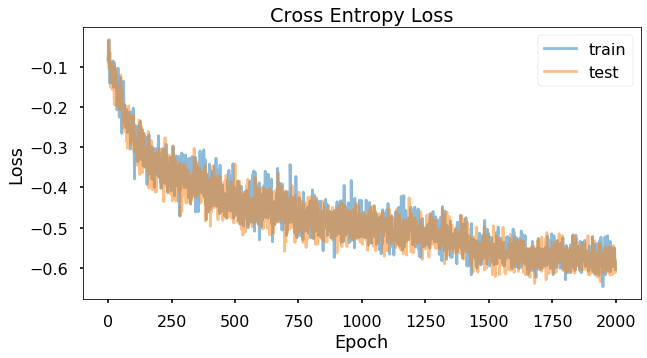

In [5]:
plot_metric_history(loss_history, title='Cross Entropy Loss')

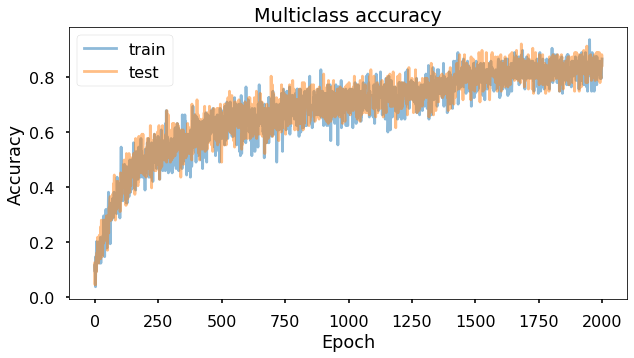

In [6]:
plot_metric_history(acc_history, title='Multiclass accuracy', ylabel='Accuracy')

## 5. Train and evaluate model with hidden layer using TF2 Cross-entropy loss

In [3]:
# define train proces with TF cro
def train(model, X, y, optimizer):
    """
    One step of train process
    
    params:
        model: model object to train
        X: data
        y: target 
        optimizer: tf optimizer
    return:
        loss_val: loss value
    """
    with tf.GradientTape() as t:
        y_pred_logit = model(X)
        loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_pred_logit))
        
    grads = t.gradient(loss_val, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    acc = accuracy(y, tf.nn.softmax(y_pred_logit))
    
    return loss_val, acc

# define evaluate proces
def evaluate(model, X, y):
    """
    One step of evaluation process
    
    params:
        model: model object to evaluate
        X: data to evaluate
        y: target 
    return:
        loss_val: loss value
    """
    y_pred_logit = model(X)
    loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_pred_logit))
    
    acc = accuracy(y, tf.nn.softmax(y_pred_logit))
    
    return loss_val, acc

In [6]:
%%time
_fix_seeds(42)
lr = 1e-2
batch_size = 128
num_steps = 1000
repeat_num = 100

loss_history_exp = []
acc_history_exp = []

for j in tqdm(range(repeat_num)):
    
    # Initialize weigts 
    W = tf.Variable(tf.random.normal([784, 10], dtype='float32'), name='weights')
    b = tf.Variable(tf.zeros([10], dtype='float32'), name='biases')
    
    # Set up model and optimier
    model = LogRegModel(W, b)
    optimizer = tf.optimizers.Adam(learning_rate=lr)

    loss_history, acc_history = one_experiment(X_train, y_train, X_test, y_test, \
                                               model, optimizer, 
                                               num_steps=num_steps,
                                               batch_size=batch_size)
        
    loss_history_exp.append(loss_history)
    acc_history_exp.append(acc_history)

100%|██████████| 100/100 [07:03<00:00,  4.24s/it]

CPU times: user 8min 50s, sys: 17 s, total: 9min 7s
Wall time: 7min 3s


In [7]:
loss_plain_mtrx = {
    'train':[],
    'test':[]
}
acc_plain_mtrx = {
    'train':[],
    'test':[]    
}

for exp_loss, exp_acc in zip(loss_history_exp, acc_history_exp):
    loss_plain_mtrx['train'].append(exp_loss['train'])
    loss_plain_mtrx['test'].append(exp_loss['test'])
    
    acc_plain_mtrx['train'].append(exp_acc['train'])
    acc_plain_mtrx['test'].append(exp_acc['test'])  
    
loss_plain_mtrx['train'] = np.array(loss_plain_mtrx['train'])
loss_plain_mtrx['test'] = np.array(loss_plain_mtrx['test'])

acc_plain_mtrx['train'] = np.array(acc_plain_mtrx['train'])
acc_plain_mtrx['test'] = np.array(acc_plain_mtrx['test'])

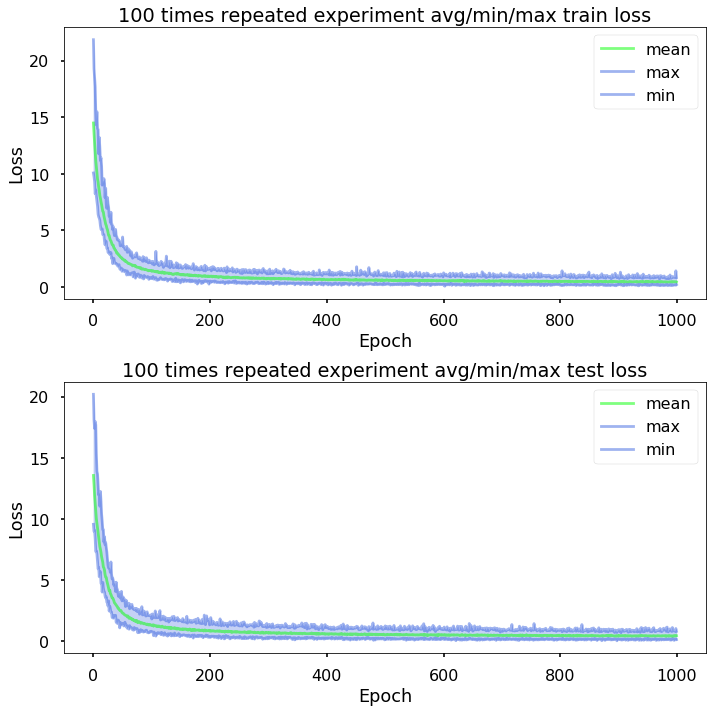

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].plot(loss_plain_mtrx['train'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[0].plot(loss_plain_mtrx['train'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[0].plot(loss_plain_mtrx['train'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[0].fill_between(list(range(1000)), 
                 loss_plain_mtrx['train'].max(axis=0),
                 loss_plain_mtrx['train'].min(axis=0), alpha=0.3, color='royalblue')

ax[0].set_title('100 times repeated experiment avg/min/max train loss' )
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(loss_plain_mtrx['test'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[1].plot(loss_plain_mtrx['test'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[1].plot(loss_plain_mtrx['test'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[1].fill_between(list(range(1000)), 
                 loss_plain_mtrx['test'].max(axis=0),
                 loss_plain_mtrx['test'].min(axis=0), alpha=0.3, color='royalblue')

ax[1].set_title('100 times repeated experiment avg/min/max test loss' )
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.tight_layout()
plt.show()

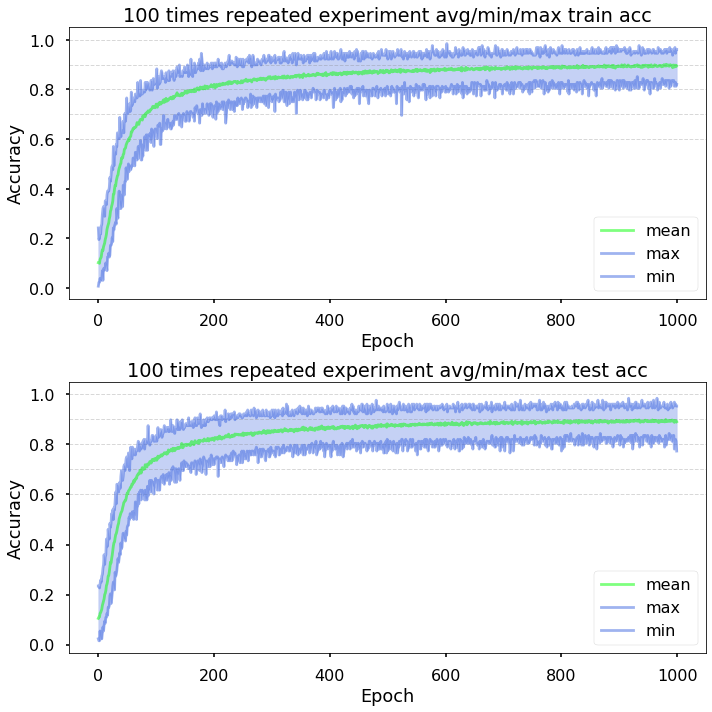

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

ax[0].axhline(y=1.0, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.9, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.8, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.7, c='grey', alpha=0.3, ls='--', lw=1)
ax[0].axhline(y=0.6, c='grey', alpha=0.3, ls='--', lw=1)

ax[0].plot(acc_plain_mtrx['train'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[0].plot(acc_plain_mtrx['train'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[0].plot(acc_plain_mtrx['train'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[0].fill_between(list(range(1000)), 
                 acc_plain_mtrx['train'].max(axis=0),
                 acc_plain_mtrx['train'].min(axis=0), alpha=0.3, color='royalblue')

ax[0].set_title('100 times repeated experiment avg/min/max train acc' )
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].axhline(y=1.0, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.9, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.8, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.7, c='grey', alpha=0.3, ls='--', lw=1)
ax[1].axhline(y=0.6, c='grey', alpha=0.3, ls='--', lw=1)

ax[1].plot(acc_plain_mtrx['test'].mean(axis=0), label='mean', alpha=0.5, c='lime')
ax[1].plot(acc_plain_mtrx['test'].max(axis=0), label='max', alpha=0.5, c='royalblue')
ax[1].plot(acc_plain_mtrx['test'].min(axis=0), label='min', alpha=0.5, c='royalblue')  
ax[1].fill_between(list(range(1000)), 
                 acc_plain_mtrx['test'].max(axis=0),
                 acc_plain_mtrx['test'].min(axis=0), alpha=0.3, color='royalblue')

ax[1].set_title('100 times repeated experiment avg/min/max test acc' )
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()